# Attempts at initial analysis

In [80]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.summarization import keywords, summarize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import utils
import csv
import multiprocessing
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser

product_info = pd.read_csv('../data/CatfoodProductInfo.csv')
reviews = pd.read_csv('../data/CatfoodReviewsInfo.csv')
df = reviews.join(product_info.set_index('product'), on='product',how='left')
# print(df.columns)
# product_info['brand'].value_counts()

In [81]:
df = df.dropna(axis=0,how='any')
brandnames = set(df['brand'].unique())
print(f'There are {len(brandnames)} brands represented across our reviews.')

nprods = len(df.groupby('product'))
nrevs = len(df)
print(f'There are {nrevs} reviews across {nprods} products')
# brandnames

There are 51 brands represented across our reviews.
There are 43300 reviews across 671 products


In [82]:
print(len(df))
exclude_words = ['Variety',]
for word in exclude_words:
    df = df[~df['product'].str.contains(word)]
    product_info = product_info[~product_info['product'].str.contains(word)]
    
print(len(df))


43300
42814


### Some viz

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


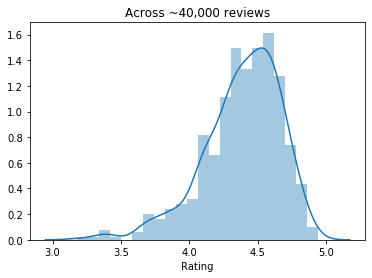

In [4]:
mean_ratings = df.groupby('product').mean()['rating']
sns.distplot(mean_ratings,kde=True)
plt.xlabel('Rating')
plt.title('Across ~40,000 reviews')
plt.savefig('plots/individual-ratings-histogram.png',bbox_inches='tight')

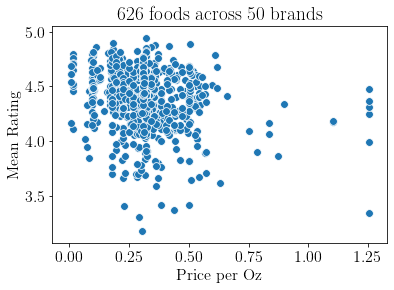

In [12]:
font = {'family' : 'Helvetica Neue',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)



ratings_vs_price = df.groupby('product').mean()[['rating','price_per_oz']]
plt.title('626 foods across 50 brands')
sns.scatterplot(x='price_per_oz',y='rating',s=60,data=ratings_vs_price)
plt.xlabel('Price per Oz');
plt.ylabel('Mean Rating');
plt.savefig('plots/rating_vs_price.png',bbox_inches='tight')

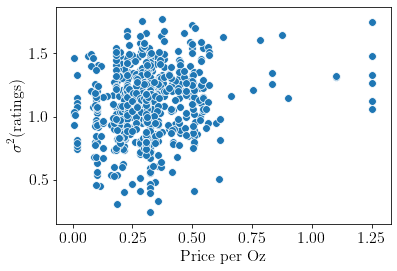

In [13]:
from scipy.stats import entropy
import numpy as np


price = df.groupby('product')['price_per_oz'].mean()
# stdevs = df.groupby('product')['rating'].apply(lambda r: entropy(r.value_counts()))
stdevs = df.groupby('product')['rating'].std()

stdev_vs_price = pd.DataFrame(data={'ppo': price, 'stdev': stdevs})
sns.scatterplot(x='ppo',y='stdev',data=stdev_vs_price,s=60)


# plt.hlines( y=np.log(2), xmin = price.min(), xmax = price.max())

# plt.title('Cat food is polarizing')
plt.xlabel('Price per Oz')
plt.ylabel("$\displaystyle \sigma^2 $(ratings)")
plt.savefig('plots/variance-vs-price.png',bbox_inches='tight')

## random tfidf stuff. skip down below

In [3]:
corpus = df['review_text']
tfidf = TfidfVectorizer(ngram_range=(1, 1), 
                        min_df=0.0001, 
                        stop_words='english')
tfidf_matrix = tfidf.fit_transform(corpus)

In [5]:
tfidf_matrix.shape

(38559, 5897)

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
remove_punct = re.compile()

### following https://towardsdatascience.com/implementing-multi-class-text-classification-with-doc2vec-df7c3812824d 
and(?)
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [83]:
# standardize text
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    for brandname in brandnames:
        df[text_field] = df[text_field].str.replace(brandname.lower(),"")

        
    return df

# Function for tokenizing
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens


# Label encode the names
le = preprocessing.LabelEncoder()
df['product_label']=le.fit_transform(df['product'])

# print(train_documents[0])

df_clean = standardize_text(df,'review_text')

In [84]:
from nltk.tokenize import RegexpTokenizer
pd.set_option('display.width',200)

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
df_clean["tokens"] = df_clean["review_text"].apply(tokenizer.tokenize)

df_clean['tokens'] = df_clean['tokens'].apply(lambda x: ' '.join( [item for item in x if item not in stop_words]))
# df_clean['tokens'] = df_clean['tokens'].apply(lambda x: [item for item in x if item not in stop_words])


all_tokens = [t.split() for t in df_clean['tokens']]
phrases = Phrases(all_tokens)
bigram = Phraser(phrases)
trigram_phrases = Phrases(bigram[all_tokens])
trigram = Phraser(phrases)

df_clean['trigrammed'] = df_clean['tokens'].apply(lambda x: trigram[x.split(' ')])



# train, test = train_test_split(df[['review_text','product_label']],test_size=0.0)

data = df_clean[['trigrammed','product_label']]
data['n_words'] = data['trigrammed'].apply(lambda r: len(r))
print(f'Number of reviews prior to dropping short ones {len(data)}')
data = data.loc[data['n_words']>=10]
print(f'Number of reviews after dropping short ones {len(data)}')
# data.head(5)

data_tagged = data.apply(
    lambda r: TaggedDocument(words=r['trigrammed'], tags=[r.product_label]), axis=1)

# train_tagged = train.apply(
#     lambda r: TaggedDocument(words=bigram[tokenize_text(r['review_text'])], tags=[r.product_label]), axis=1)
# test_tagged = test.apply(
#     lambda r: TaggedDocument(words=bigram[tokenize_text(r['review_text'])], tags=[r.product_label]), axis=1)

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of reviews prior to dropping short ones 42814
Number of reviews after dropping short ones 30557


In [85]:
pd.set_option('display.max_colwidth',200)
data.sample(5)

,trigrammed,product_label,n_words
3568,"[love, peel, dump, two, separate, dishes, cats, dont, decide, whether, split, evenly]",345,12
18624,"[cat, raised, dogs, eat, anything, beef, beef, must, horsemeat, eats, every_drop]",143,11
16734,"[cat, sweet, pea, loves, dinner, way, always, hand, love, chewy, order, within, 1, two_days, haver, order]",190,16
30395,"[loves, kitten, food, finishes, fast, get, big_boy, food, cats, like, wth, lol]",468,12
22219,"[miracle, found, new, food, adopted, rescue, kitty_sapphire, likes, spoiled, finicky, believes, treats, called, soup, stew, form, even, pour, dry, food, even, hesitate, ate, every_bite, definitely...",649,25


In [86]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, 
                     workers=cores, alpha=0.025, min_alpha=0.001)
model_dm = Doc2Vec(dm=1, vector_size=300, window=10, negative=5, hs=0, min_count=2, sample=0,
                   workers=cores, alpha=0.025, min_alpha = 0.001)
model_dbow.build_vocab([x for x in tqdm(data_tagged.values)])
model_dm.build_vocab([x for x in tqdm(data_tagged.values)])

100%|██████████| 30557/30557 [00:00<00:00, 1837337.97it/s]


In [87]:
%%time
cores = multiprocessing.cpu_count()
train_data = utils.shuffle(data_tagged)

model_dbow.train(train_data, total_examples=len(train_data), epochs=20)
model_dm.train(train_data, total_examples=len(train_data), epochs=20)

CPU times: user 4min 4s, sys: 18.8 s, total: 4min 23s
Wall time: 2min 55s


In [ ]:
# # Takes a long time to run!

# def vec_for_learning(model, tagged_docs):
#     sents = tagged_docs.values
#     targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
#     return targets, regressors


# y_train, X_train = vec_for_learning(model_dbow, train_tagged)
# y_test, X_test = vec_for_learning(model_dbow, test_tagged)
# logreg = LogisticRegression(n_jobs=1, C=1e5)
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)
# from sklearn.metrics import accuracy_score, f1_score
# print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
# print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [88]:
df.sample(4)[['product','product_label']]

,product,product_label
15354,"Wellness Morsels Chicken Entree Grain-Free Canned Cat Food, 5.5-oz, case of 24",634
39698,"Fussie Cat Super Premium Chicken Formula in Gravy Grain-Free Canned Cat Food, 2.82-oz, case of 24",265
42940,"Purina Muse Natural Grain-Free Filets Cat Food Trays, Chicken & Salmon Recipe in Chicken Broth, 2.1-oz, case of 10",432
26704,"Nutro Max Adult With Savory Duck Chunks in Sauce Canned Cat Food, 3-oz, case of 24",411


In [89]:
label_decoder = df[['product_label','product']].set_index('product_label').to_dict()['product']
label_encoder = df[['product_label','product']].set_index('product').to_dict()['product_label']

num_returned = 50
results_shown = 10

pd.set_option('display.max_colwidth', 200)
positives = [67,2]
negatives = [228,361]
positives = [2]
negatives = []

similarity_results = pd.DataFrame(index = product_info['product'],columns = ['dbow_rank','dm_rank','combined'])
similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
#     print(similar_items)
decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

print("Dbow model similarities:")
for (rank, product) in enumerate(decoded_dbow):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dbow_rank"] = rank
#     print(f'{rank}: {name}, {score}')

print("\n DM model similarities:")
for (rank, product) in enumerate(decoded_dm):
    name = product[0]
    score = product[1]
    similarity_results.loc[name,"dm_rank"] = rank
#     print(f'{rank}: {name}, {score}')

similarity_results.fillna(value=num_returned+1,inplace=True)
similarity_results["combined"] = (similarity_results["dbow_rank"] + similarity_results["dm_rank"])/2

liked = [label_decoder[i] for i in positives]
disliked = [label_decoder[i] for i in negatives]
print(f'Cat liked: {liked}. Cat disliked: {disliked}')
print("\n Combined scores")
similarity_results.sort_values(by='combined',ascending=True).drop(columns=['dbow_rank','dm_rank'],axis=0).head(results_shown)




Dbow model similarities:

 DM model similarities:
Cat liked: ['9 Lives Tender Morsels with Real Flaked Tuna & Egg Bits in Sauce Canned Cat Food, 5.5-oz, case of 24']. Cat disliked: []

 Combined scores


,combined
product,
"Friskies Savory Shreds with Whitefish & Sardines in Sauce Canned Cat Food, 5.5-oz, case of 24",1.0
"Fancy Feast Grilled Tuna Feast in Gravy Canned Cat Food, 3-oz, case of 24",4.5
"Fancy Feast Flaked Salmon & Ocean Whitefish Feast Canned Cat Food, 3-oz, case of 24",5.0
"Fancy Feast Medleys Wild Salmon Tuscany Canned Cat Food, 3-oz, case of 24",6.5
"Fancy Feast Medleys Tuna Tuscany Canned Cat Food, 3-oz, case of 24",7.5
"Fancy Feast Flaked Tuna & Mackerel Feast Canned Cat Food, 3-oz, case of 24",9.0
"Meow Mix Tender Favorites with Real Chicken & Liver in Sauce Cat Food Trays, 2.75-oz, case of 12",9.5
"Fancy Feast Grilled Beef Feast in Gravy Canned Cat Food, 3-oz, case of 24",14.0
"Fancy Feast Sliced Chicken Hearts & Liver Feast in Gravy Canned Cat Food, 3-oz, case of 24",14.0


In [90]:
filter_products = [item in df['product'].values for item in product_info['product']]
af = product_info[filter_products]
af['product_label']=le.fit_transform(af['product'])
brand_list = {name : brand for (name,brand) in zip(af['product'],af['brand'])}

sample_brands = ['Fancy Feast',
#                  'Friskies',
                 'Blue Buffalo',
                 'Purina Pro Plan', 
                 'Hills Prescription Diet',
                 'Nutro',
#                  'Wellness',
                ]

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [91]:
vec_list = {name : model_dbow.docvecs[x] for (name,x) in zip(af['product'].to_list(),af['product_label'].to_list()) if brand_list[name] in sample_brands
           };

embeddings = pd.DataFrame.from_dict(vec_list,orient='index')

/Users/danielben-zion/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


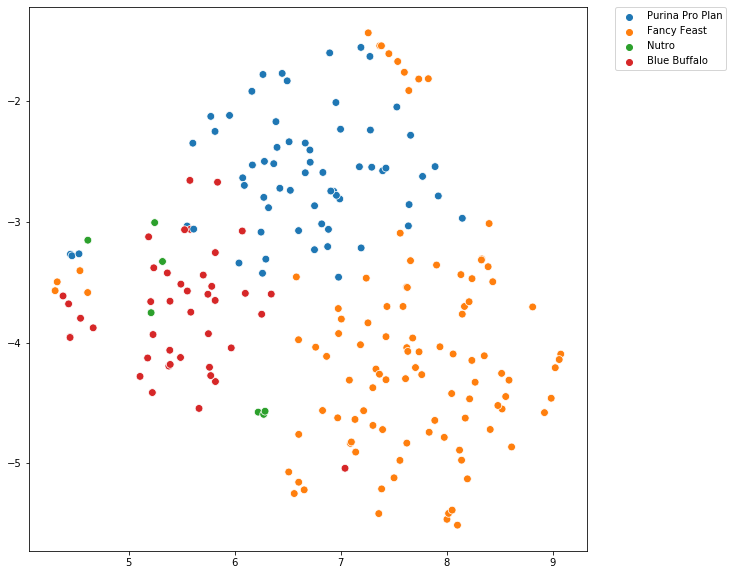

In [92]:
# from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import umap 

%matplotlib inline
# pca = PCA(n_components=2)
embeddings_viz = umap.UMAP(min_dist = 0.0,
                          n_neighbors = 20,
                          metric='euclidean').fit_transform(embeddings)
brand_name = [brand_list[name] for name in embeddings.index]

fig = plt.figure(figsize=(10,10))
sns.scatterplot(x=embeddings_viz[:,0], y=embeddings_viz[:,1],hue = brand_name, s = 60)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.savefig('plots/BrandSeparation.png',bbox_inches='tight')



In [184]:
import pickle
# save what we need to use in the backend

# the model
model_dbow.save('catfood-d2v-dbow.model')
model_dm.save('catfood-d2v-dm.model')

# the label decoder
with open("label-decoder.pkl","wb") as f:
    pickle.dump(label_decoder,f)
    
# the label encoder
with open("label-encoder.pkl","wb") as f:
    pickle.dump(label_encoder,f)



### validation attempts?

In [112]:
author_count = df.groupby('review_author')['review_author'].count()
authorgroup = author_count[(author_count > 10) & (author_count < 20)]
# authorgroup
# authorgroup = author_count

review_author
3catmom           11
3catsownme        12
Abby              17
Alex              17
Allie             12
Amber             16
Andrea            16
Andy              12
Angel             15
April             13
Ashley            14
BabyJaneHudson    14
Barbfan           12
Bear              14
Beau              11
Becca             13
Belle             14
Betsy             14
Bill              15
Bobbi             16
BobsBalcony       15
Boots             12
Brenda            17
Buffy             18
Bunny             13
Callie            18
Carla             12
CarolinaCat       14
Carrie            13
Casey             18
                  ..
Tish              12
Toni              13
Tracy             15
Trish             14
Vicki             16
Yummy             19
Zoey              13
bellasmom         13
braven1612        11
capjoe            11
cathy             11
catowner          12
cats              18
cindy             12
crazycatlady      14
debswe            11

In [108]:
pd.set_option('display.max_colwidth',200)
df[df['review_author']=='CarolinaCat'][['product','rating','review_text','product_label']]

,product,rating,review_text,product_label
804,"I and Love and You Oh My Cod! Pate Grain-Free Canned Cat Food, 3-oz, case of 24",5,i always feed my cats a variety of canned foods in the evening and this flavor got a lot of attention when i first opened it i hope they stay enthusiastic about it it's always nice to find a hea...,339
1414,"Tiki Cat Tahitian Grill Sardine Cutlets Grain-Free Canned Cat Food, 2.8-oz, case of 12",4,"when i find food still in the bowl when i get up in the morning, it tells me my cats don't particularly like something this was the case with this food",593
10237,"Weruva Cats in the Kitchen Lamb Burgini Lamb Au Jus Grain-Free Canned Cat Food, 3.2-oz, case of 24",3,my cats seemed to like glam and punk pretty well but this variety has been a dud with them i really like the brand but not this flavor,646
12778,"Blue Buffalo Healthy Gourmet Flaked Fish & Shrimp Entree in Gravy Canned Cat Food, 5.5-oz, case of 24",5,i wasn't sure if my cats would eat this or not since they often don't like foods that have lumps but they are enthusiastic about it definitely a keeper with my 7 kitties,38
15566,"Wellness Complete Health Chicken & Lobster Formula Canned Cat Food, 12.5-oz, case of 12",5,this flavor has been a big hit with all of my gang i will definitely make it part of my regular chewy orders in the future,621
16148,"Weruva Truluxe Pretty In Pink with Salmon in Gravy Grain-Free Canned Cat Food, 3-oz, case of 24",4,this is one of those flavors that my cats will eat but is not one of their favorites it is usually all gone by morning but i see them eat other flavors before this i am a big fan but i find tha...,658
24575,"Purina Beyond Grain-Free Trout & Catfish Pate Recipe Canned Cat Food, 3-oz, case of 12",5,all my cats really seem to like this which is saying a lot i have one that has verged into a picky eater but this is on her aok list,424
28484,"Fancy Feast Classic Tender Beef & Liver Feast Canned Cat Food, 3-oz, case of 24",2,i have 7 cats and none of them liked this food they simply do not like beef flavored cat foods,106
33830,"Blue Buffalo Basics Limited Ingredient Grain-Free Indoor Fish & Potato Entree Adult Canned Cat Food, 3-oz, case of 24",4,this has probably been one of the poorest selections of cat food that my cats have been given they eventually eat all of it but it is usually the last to go i probably won't reorder,30
34136,"Weruva Nine Liver with Chicken & Chicken Liver in Gravy Grain-Free Canned Cat Food, 5.5-oz, case of 24",3,my cats have little enthusiasm for this flavor makes great cat food but this variety is not a winner with my crew,654


In [68]:
positives = [343,39]
negatives = [108,653]

In [95]:
num_returned = 1000
results_shown = 10

similarity_results = pd.DataFrame(index = product_info['product'],columns = ['dbow_rank','dm_rank','combined'])
similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
#     print(similar_items)
decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

def scale_scores(df,field):
    df[field] = df[field].apply(lambda r: r/df[field].max())
    return df

dbow_results = pd.DataFrame(decoded_dbow,columns=['product','sim_score'])
dbow_results = scale_scores(dbow_results,'sim_score')

dm_results = pd.DataFrame(decoded_dm,columns=['product','sim_score'])
dm_results = scale_scores(dm_results,'sim_score')

combined_results = dbow_results.set_index('product').join(dm_results.set_index('product'), how = 'left', 
                                    lsuffix = '_db', rsuffix = '_dm')


combined_results['avg_sim'] = (combined_results['sim_score_db'] + combined_results['sim_score_dm'])/2
combined_results.sort_values(by='avg_sim',ascending=False).head()
    
    
# print("Dbow model similarities:")
# for (rank, product) in enumerate(decoded_dbow):
#     name = product[0]
#     score = product[1]
#     similarity_results.loc[name,"dbow_rank"] = rank
#     print(f'{rank}: {name}, {score}')

# print("\n DM model similarities:")
# for (rank, product) in enumerate(decoded_dm):
#     name = product[0]
#     score = product[1]
#     similarity_results.loc[name,"dm_rank"] = rank
#     print(f'{rank}: {name}, {score}')

# similarity_results.fillna(value=num_returned+1,inplace=True)
# similarity_results["combined"] = (similarity_results["dbow_rank"] + similarity_results["dm_rank"])/2

# liked = [label_decoder[i] for i in positives]
# disliked = [label_decoder[i] for i in negatives]
# print(f'Cat liked: {liked}. Cat disliked: {disliked}')
# print("\n Combined scores")
# output = similarity_results.sort_values(by='combined',ascending=True).drop(columns=['dbow_rank','dm_rank'],axis=0).head(results_shown)
# output

,sim_score_db,sim_score_dm,avg_sim
product,,,
"Friskies Savory Shreds with Whitefish & Sardines in Sauce Canned Cat Food, 5.5-oz, case of 24",0.959826,1.000000,0.979913
"Fancy Feast Grilled Tuna Feast in Gravy Canned Cat Food, 3-oz, case of 24",0.911591,0.990181,0.950886
"Fancy Feast Flaked Salmon & Ocean Whitefish Feast Canned Cat Food, 3-oz, case of 24",0.919607,0.956026,0.937817
"Fancy Feast Medleys Wild Salmon Tuscany Canned Cat Food, 3-oz, case of 24",0.923430,0.910681,0.917055
"Meow Mix Tender Favorites with Real Chicken & Liver in Sauce Cat Food Trays, 2.75-oz, case of 12",0.890384,0.943115,0.916750


In [96]:
test = df[df['review_author']=='CarolinaCat'][['product','rating']].set_index('product')

In [97]:
val = test.join(combined_results,how='left')

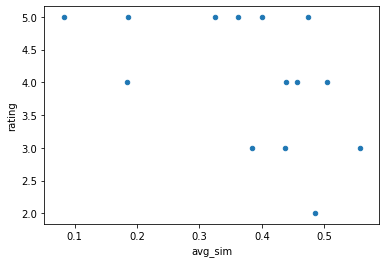

In [98]:
val.plot.scatter(x='avg_sim',y='rating')

In [113]:
import numpy as np
def scale_scores(df,field):
    scaleby = max(np.abs(df[field].min()),np.abs(df[field].max()))
    df[field] = df[field]/scaleby
    return df

def generate_val_data(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    if len(userdata.groupby('rating').count()) == 1:
        return
    
    

    
    low_rankings = userdata[userdata['rating'] <= 3].sort_values(by='rating',ascending=True)
    high_rankings = userdata[userdata['rating'] >= 4].sort_values(by='rating',ascending=False)
    
    
#     if len(low_rankings) < 3:
#         return
    
    
    negatives = [val for val in low_rankings.head(2)['product_label']]
    positives = [val for val in high_rankings.head(2)['product_label']]
    
    similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)

    decoded_dbow = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dbow]
    decoded_dm = [(label_decoder[label],similarity) for (label,similarity) in similar_items_dm]

    dbow_results = pd.DataFrame(decoded_dbow,columns=['product','sim_score'])
    dbow_results = scale_scores(dbow_results,'sim_score')

    dm_results = pd.DataFrame(decoded_dm,columns=['product','sim_score'])
    dm_results = scale_scores(dm_results,'sim_score')

    combined_results = dbow_results.set_index('product').join(dm_results.set_index('product'), how = 'left', 
                                        lsuffix = '_db', rsuffix = '_dm')


    combined_results['avg_sim'] = (combined_results['sim_score_db'] + combined_results['sim_score_dm'])/2
    
    tmp = userdata[['product','rating']].set_index('product')
    val = tmp.join(combined_results,how='left')
    val.dropna(how='any',axis=0,inplace=True)
    
#     val['rating'] = val['rating'] - val['rating'].mean()
    
    return val

In [114]:
val = pd.concat([generate_val_data(user) for user in authorgroup.index],axis=0)

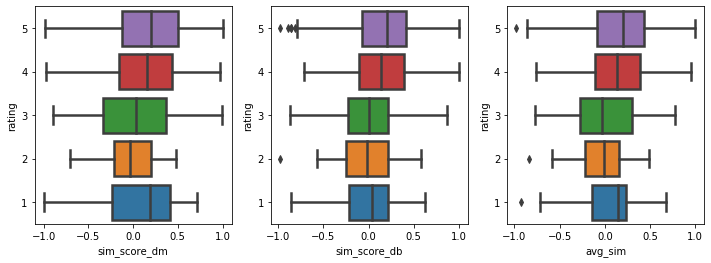

In [115]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))


a = sns.boxplot(x='sim_score_dm',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[0])
a.invert_yaxis()

b = sns.boxplot(x='sim_score_db',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[1])
b.invert_yaxis()

c = sns.boxplot(x='avg_sim',y='rating',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[2])
c.invert_yaxis()

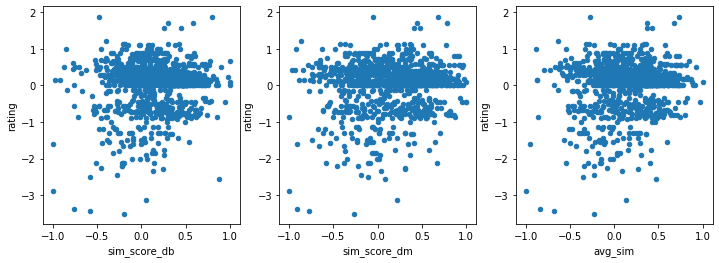

In [303]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))

val.plot.scatter(x='sim_score_db',y='rating',ax=axes[0])
val.plot.scatter(x='sim_score_dm',y='rating',ax=axes[1])
val.plot.scatter(x='avg_sim',y='rating',ax=axes[2])

## Experimenting with another plot format

In [392]:
def into_ranked_dataframe(sim):
    """ Takes the output of doc2vec most_similar and puts it into
    a dataframe thats nice to work with """
    tmp = pd.DataFrame(sim,columns = ['product_label','sim_score'])
    tmp['rank'] = tmp.index
    tmp['name'] = tmp['product_label'].apply(lambda r: label_decoder[r])
    
    return tmp[['name','rank']].set_index('name')

def generate_rankings_data(user):
    num_returned = 1000
    userdata = df[df['review_author']==user]
    
    if len(userdata.groupby('rating').count()) == 1:
        return

    
    low_rankings = userdata[userdata['rating'] <= 3].sort_values(by='rating',ascending=True)
    high_rankings = userdata[userdata['rating'] >= 4].sort_values(by='rating',ascending=False)
    
    if len(low_rankings) < 3:
        return
    
    negatives = [val for val in low_rankings.head(2)['product_label']]
    positives = [val for val in high_rankings.head(2)['product_label']]
    
    
    similar_items_dbow = model_dbow.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    similar_items_dm = model_dm.docvecs.most_similar(positive=positives,negative = negatives,topn=num_returned)
    
    db_frame = into_ranked_dataframe(similar_items_dbow)
    dm_frame = into_ranked_dataframe(similar_items_dm)

    joined = db_frame.join(dm_frame,lsuffix='_db',rsuffix='_dm')
    joined['avg_rank'] = joined.mean(axis=1)

    tmp = userdata[['product','rating']].set_index('product')
    val = tmp.join(joined,how='left')
    val.dropna(how='any',axis=0,inplace=True)
    
#     val[['rank_db','rank_dm','avg_rank']] = val[['rank_db','rank_dm','avg_rank']]/val[['rank_db','rank_dm','avg_rank']].max(axis=0)
    
    return val

In [393]:
val = pd.concat([generate_rankings_data(user) for user in authorgroup.index],axis=0)

In [394]:
val.head()

,rating,rank_db,rank_dm,avg_rank
"Fancy Feast Classic Tender Beef Feast Canned Cat Food, 3-oz, case of 24",3,532.0,226.0,379.0
"Tiny Tiger Pate Salmon Recipe Grain-Free Canned Cat Food, 3-oz, case of 24",3,96.0,498.0,297.0
"Wellness CORE Natural Grain Free Turkey & Duck Pate Canned Cat Food, 3-oz, case of 12",4,434.0,649.0,541.5
"Purina Pro Plan Chicken, Pasta & Spinach Entree in Gravy Canned Cat Food, 3-oz, case of 24",4,348.0,248.0,298.0
"Purina Pro Plan Classic Beef & Carrots Entree Grain-Free Canned Cat Food, 3-oz, case of 24",5,450.0,251.0,350.5


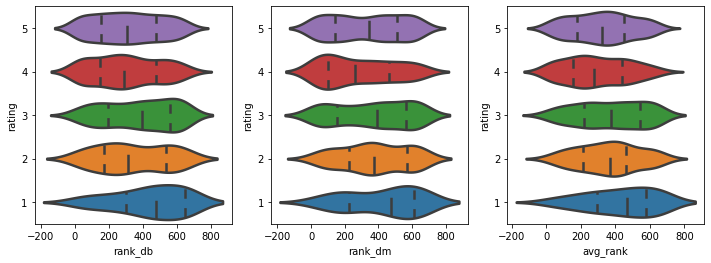

In [395]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12,4))


a = sns.violinplot(x='rank_db',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[0])
a.invert_yaxis()

b = sns.violinplot(x='rank_dm',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[1])
b.invert_yaxis()

c = sns.violinplot(x='avg_rank',y='rating',inner='quartiles',
                    dodge=False,linewidth=2.5,orient='h',data=val,ax = axes[2])
c.invert_yaxis()

In [380]:
tmp = generate_rankings_data(user)

In [386]:
tmp[['rank_db','rank_dm','avg_rank']] = tmp[['rank_db','rank_dm','avg_rank']]/tmp[['rank_db','rank_dm','avg_rank']].max(axis=0)

In [387]:
tmp

,rating,rank_db,rank_dm,avg_rank
product,,,,
"Tiki Cat Tahitian Grill Sardine Cutlets Grain-Free Canned Cat Food, 2.8-oz, case of 12",4,0.695988,0.820783,0.762050
"Wellness Complete Health Chicken & Lobster Formula Canned Cat Food, 12.5-oz, case of 12",5,0.385802,0.262048,0.324407
"Weruva Truluxe Pretty In Pink with Salmon in Gravy Grain-Free Canned Cat Food, 3-oz, case of 24",4,0.407407,0.558735,0.485845
"Purina Beyond Grain-Free Trout & Catfish Pate Recipe Canned Cat Food, 3-oz, case of 12",5,0.762346,0.365964,0.563887
"Blue Buffalo Basics Limited Ingredient Grain-Free Indoor Fish & Potato Entree Adult Canned Cat Food, 3-oz, case of 24",4,0.404321,0.293675,0.349656
"Weruva Nine Liver with Chicken & Chicken Liver in Gravy Grain-Free Canned Cat Food, 5.5-oz, case of 24",3,0.944444,1.000000,0.976282
"Tiki Cat Makaha Grill Mackerel & Sardine in Calamari Consomme Grain-Free Canned Cat Food, 6-oz, case of 8",4,0.166667,0.942771,0.561591
"Blue Buffalo Wilderness Wild Delights Flaked Chicken & Turkey Grain-Free Canned Cat Food, 5.5-oz, case of 24",5,0.020062,0.012048,0.016067
"Weruva Truluxe Mediterranean Harvest with Tuna & Veggies in Gravy Grain-Free Canned Cat Food, 3-oz, case of 24",3,1.000000,0.992470,1.000000
